# **Proyecto DataScience III - Análisis de imágenes de MNIST**

**Alumno**: Rodrigo Tomas Gonzalez \
**Comisión**: 60960 \
**Tutores**: Mariano Rodas y Juan Cruz Alric \
**Profesor**: Ignacio Russo Locati

*Fecha: 26-10-2024*

**Abstracto**

Este informe presenta un análisis del dataset MNIST, que contiene imágenes de dígitos escritos a mano, con el objetivo de desarrollar un modelo de clasificación de imágenes utilizando una red neuronal simple. El conjunto de datos está compuesto por 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba, cada una con dimensiones de 28x28 píxeles y representadas en escala de grises. Se realizaron análisis exploratorios de datos (EDA) para comprender la estructura y distribución del dataset, identificando aspectos clave como el equilibrio entre clases, la media y la varianza de los píxeles.

Para abordar la tarea de clasificación, se diseñó una red neuronal utilizando la arquitectura nn.Sequential de PyTorch. Esta red consiste en una capa de aplanamiento que transforma las imágenes de 28x28 píxeles en vectores de 784 elementos, seguida de una capa totalmente conectada con 256 neuronas activadas por la función ReLU, y culmina en una capa de salida con 10 neuronas que representan las clases de dígitos del 0 al 9. Esta estructura permite modelar la complejidad inherente al reconocimiento de patrones en las imágenes de dígitos.

El análisis exploratorio reveló que el conjunto de datos está bien equilibrado en términos de la distribución de las diferentes clases, lo que es fundamental para evitar sesgos en el modelo. Los resultados preliminares sugieren que la red neuronal puede aprender a distinguir entre los diferentes dígitos, aunque se requiere un ajuste adicional de los hiperparámetros y un análisis más profundo de las métricas de rendimiento para optimizar el modelo.



---

**Importación de librerías**

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision
from IPython import display
from torchvision import transforms
from torch.utils import data
import random




---


**Importación del dataset**



In [26]:
def load_data_mnist(batch_size, resize=None):
    # Definir las transformaciones (cambiar tamaño y convertir a tensor)
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    # Descargar y cargar el dataset MNIST
    mnist_train = torchvision.datasets.MNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)

    # Crear los DataLoaders
    return (
        data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=1),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=1)
    )

Se utilizará un tamaño de batch de 256.

In [27]:
batch_size = 256
train_iter, test_iter = load_data_mnist(batch_size)



---


**Análsis exploratorio de datos**

Primero se analizará el tamaño de las imágenes.

In [28]:
images, labels = next(iter(train_iter))
image_size = images[0].size()
height, width = image_size[1], image_size[2]
print(f"Las imágenes tienen un tamaño de {height}x{width} píxeles.")

Las imágenes tienen un tamaño de 28x28 píxeles.


Notamos que las imágenes son de 28 x 28 pixels (total 784 pixeles)

---
Como ya se dijo anteriormente, el dataset cuenta con imágenes de digitos (del 0 al 9) escritos a mano. Analizaremos a continuación si el dataset esta balanceado, es decir, hay una cantidad pareja de cada número.

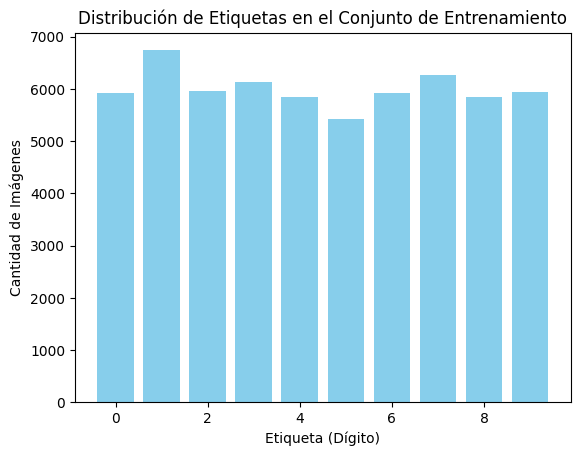

In [29]:
label_counts = {i: 0 for i in range(10)}

for _, labels in train_iter:
    for label in labels:
        label_counts[label.item()] += 1

plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("Etiqueta (Dígito)")
plt.ylabel("Cantidad de Imágenes")
plt.title("Distribución de Etiquetas en el Conjunto de Entrenamiento")
plt.show()

Se observa que el dataset está balanceado y hay aproximadamente entre 5000 y 7000 imágenes por número.



---
A continuación observaremos algunas imágenes del dataset:


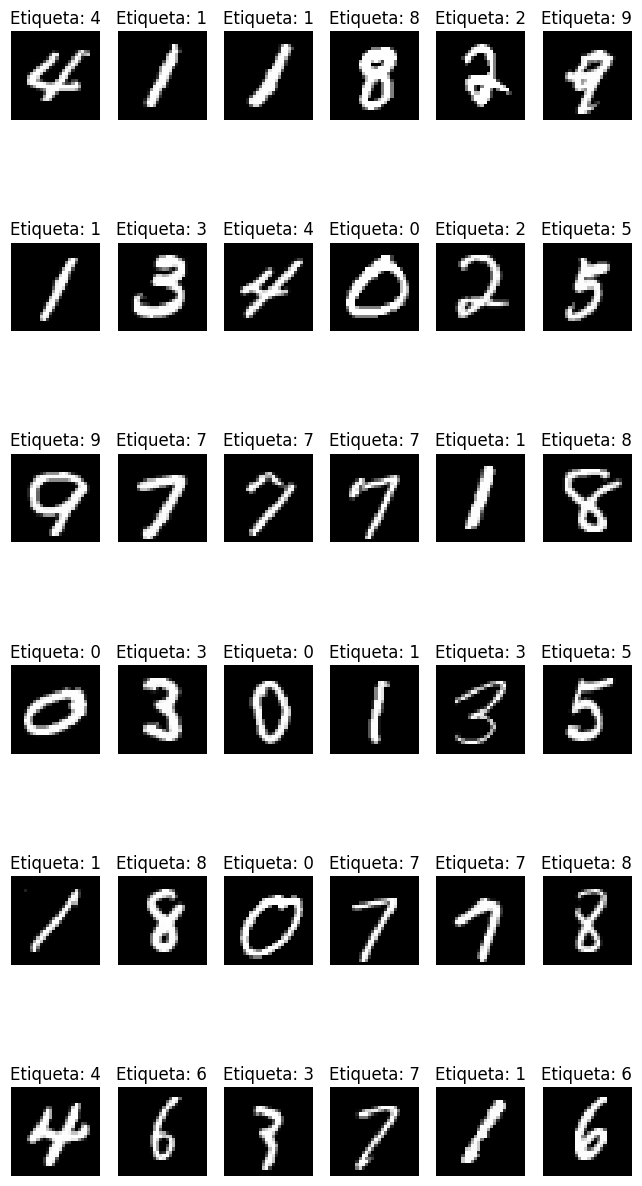

In [30]:
images, labels = next(iter(train_iter))

fig, axes = plt.subplots(6, 6, figsize=(8, 16))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(0), cmap='gray')
    ax.set_title(f"Etiqueta: {labels[i].item()}")
    ax.axis('off')

plt.show()

Se observa que todas las imágenes son efectivamente números escritos a mano alzada, en color blanco y fondo negro.



---


A continuación analizaremos los pixeles de las imágenes.

In [31]:
def calculate_stats(data_iter):
    total_sum, total_sum_sq, total_count = 0, 0, 0

    # Recorrer todas las imágenes del dataset
    for images, _ in data_iter:
        total_sum += images.sum()
        total_sum_sq += (images ** 2).sum()
        total_count += images.numel()

    mean = total_sum / total_count
    std = ((total_sum_sq / total_count) - mean ** 2).sqrt()
    return mean.item(), std.item()

mean, std = calculate_stats(train_iter)
print(f"Media de los píxeles: {mean:.4f}, Desviación estándar: {std:.4f}")

Media de los píxeles: 0.1307, Desviación estándar: 0.3081


Notamos que el valor promedio de los pixeles es 0.13 y la desviación estándar es 0.31. Veremos en el próximo gráfico la distribución.

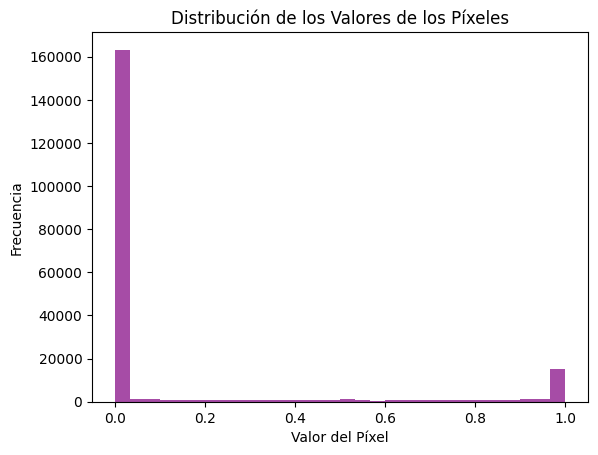

In [32]:
# Concatenar todas las imágenes de un lote en un solo array
pixels = images.view(-1).numpy()

# Graficar el histograma de los valores de los píxeles
plt.hist(pixels, bins=30, range=(0, 1), color='purple', alpha=0.7)
plt.title("Distribución de los Valores de los Píxeles")
plt.xlabel("Valor del Píxel")
plt.ylabel("Frecuencia")
plt.show()

Se observa que la mayoría de los pixeles son 0 o 1 (con muy pocos en el rango intermedio).



---

A continuación analizaremos como están compuestos los pixeles para cada número escrito a mano.

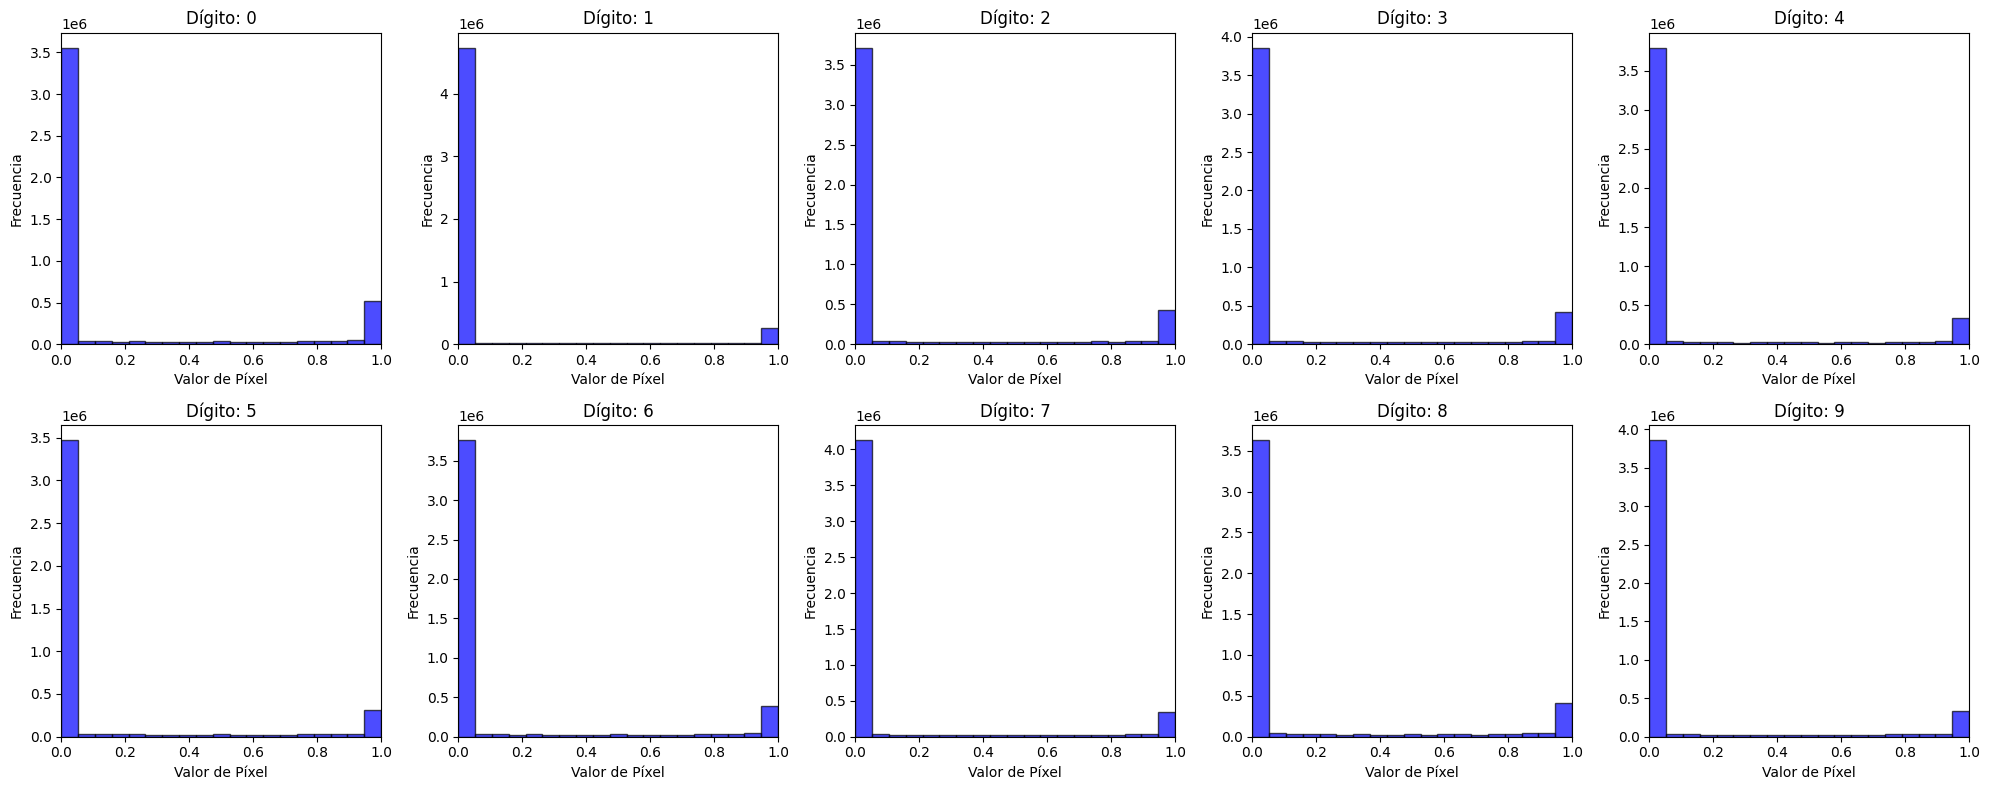

In [33]:

pixels_per_class = [[] for _ in range(10)]


for images, labels in train_iter:
    for i in range(images.size(0)):
        label = labels[i].item()
        pixels_per_class[label].extend(images[i].flatten().tolist())


fig, ax = plt.subplots(2, 5, figsize=(20, 8))
bins = np.linspace(0, 1, 20)


for i in range(10):
    ax[i // 5, i % 5].hist(pixels_per_class[i], bins=bins, alpha=0.7, color='blue', edgecolor='black')
    ax[i // 5, i % 5].set_title(f'Dígito: {i}')
    ax[i // 5, i % 5].set_xlim(0, 1)

    ax[i // 5, i % 5].set_xlabel('Valor de Píxel')
    ax[i // 5, i % 5].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Se observa que dicha distribución se aplica a todos los números analizados.



---
**Modelo de redes neuronales**


A continuación aplicaremos el modelo de redes neuronales.

Primero definimos la función accuracy para analizar la precisión del modelo en cada iteración.

In [34]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

A continuación definimos el modelo e inicializamos.

In [35]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

Definimos el batch size, la tasa de aprendizaje y el número de iteraciones. También definimos la función de pérdida y el entrenador.

In [36]:
batch_size, lr, num_epochs = 256, 0.1, 25
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

Entrenamos al modelo

In [37]:
for epoch in range(num_epochs):
    L = 0.0
    N = 0
    Acc = 0.0
    TestAcc = 0.0
    TestN = 0
    for X, y in train_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.mean().backward()
        trainer.step()
        L += l.sum()
        N += l.numel()
        Acc += accuracy(net(X), y)
    for X, y in test_iter:
        TestN += y.numel()
        TestAcc += accuracy(net(X), y)
    print(f'epoch {epoch + 1}, loss {(L/N):f}\
          , train accuracy  {(Acc/N):f}, test accuracy {(TestAcc/TestN):f}')

epoch 1, loss 1.039089          , train accuracy  0.737883, test accuracy 0.888700
epoch 2, loss 0.379893          , train accuracy  0.900467, test accuracy 0.905100
epoch 3, loss 0.320411          , train accuracy  0.914150, test accuracy 0.914400
epoch 4, loss 0.287662          , train accuracy  0.923383, test accuracy 0.922500
epoch 5, loss 0.262452          , train accuracy  0.930333, test accuracy 0.932700
epoch 6, loss 0.240408          , train accuracy  0.936850, test accuracy 0.934400
epoch 7, loss 0.222159          , train accuracy  0.942750, test accuracy 0.937500
epoch 8, loss 0.205966          , train accuracy  0.947117, test accuracy 0.944400
epoch 9, loss 0.191927          , train accuracy  0.950417, test accuracy 0.947400
epoch 10, loss 0.179392          , train accuracy  0.954050, test accuracy 0.950500
epoch 11, loss 0.168082          , train accuracy  0.957450, test accuracy 0.952800
epoch 12, loss 0.158173          , train accuracy  0.960267, test accuracy 0.954400
e

**Conclusiones del Modelo**

Pérdida en Disminución: La pérdida (loss) disminuye constantemente a lo largo de las 25 épocas, lo que indica un buen proceso de aprendizaje.

Precisión del Test: La precisión del test (test accuracy) muestra un aumento significativo, comenzando en 0.89 y alcanzando 0.97. Esto sugiere que el modelo se generaliza bien a datos no vistos, lo cual es un indicador positivo de su desempeño.

Tendencia Positiva: La tendencia en el aumento de precisión del test sugiere que el modelo sigue aprendiendo. Esto es alentador y podría indicar que se pueden explorar épocas adicionales o ajustes de hiperparámetros para potencialmente mejorar aún más el rendimiento.

En resumen, el modelo muestra una excelente precisión en el conjunto de prueba, lo que sugiere que está bien capacitado para clasificar dígitos en el conjunto de datos MNIST.

**Prueba del modelo**

A continuación, se prueba el modelo para imágenes random de números para ver como clasifica.

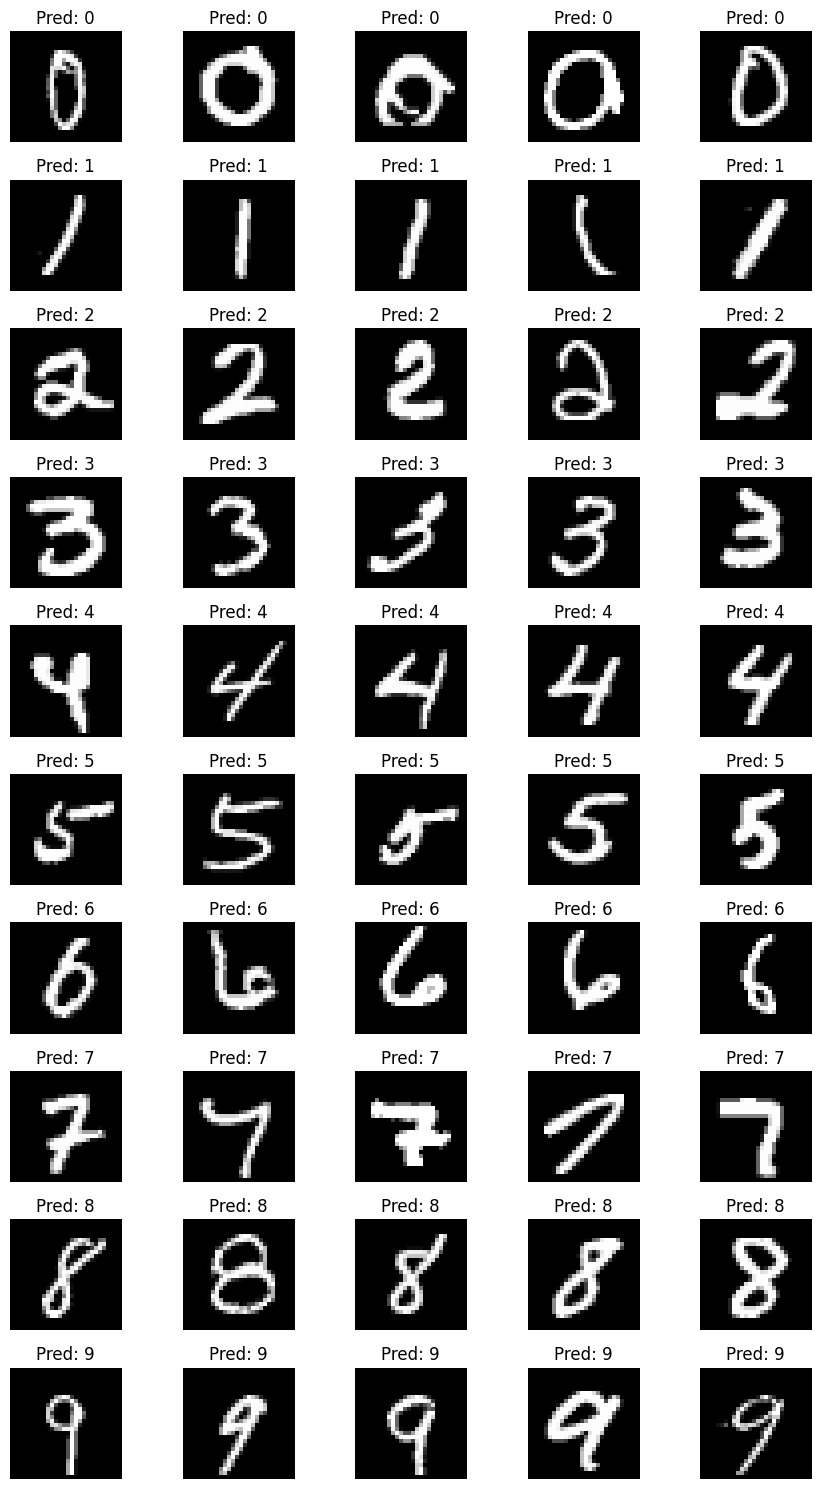

In [38]:
def plot_sample_predictions(model, data_iter, num_samples=5):
    model.eval()
    images_by_class = {i: [] for i in range(10)}
    for images, labels in data_iter:
        for img, label in zip(images, labels):
            images_by_class[label.item()].append(img)
            if all(len(images_by_class[i]) >= num_samples for i in range(10)):
                break
        if all(len(images_by_class[i]) >= num_samples for i in range(10)):
            break
    fig, axes = plt.subplots(10, num_samples, figsize=(9, 15))

    for i in range(10):
        random_samples = random.sample(images_by_class[i], num_samples)
        for j, img in enumerate(random_samples):
            ax = axes[i, j]
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
            with torch.no_grad():
                output = model(img.unsqueeze(0))
                predicted_label = output.argmax(dim=1).item()
                ax.set_title(f'Pred: {predicted_label}')
    plt.tight_layout()
    plt.show()

plot_sample_predictions(net, train_iter, num_samples=5)

Notar que el modelo funciona muy bien a la hora de etiquetar los números escritos a mano.



---
**Conclusión**

El análisis del dataset MNIST y la implementación del modelo de clasificación de dígitos han demostrado ser un ejercicio efectivo en el uso de redes neuronales para la identificación de patrones en datos visuales. A través del proceso de entrenamiento, el modelo ha aprendido a reconocer las características distintivas de cada dígito manuscrito, logrando una precisión notable en las predicciones. Los resultados del entrenamiento y la validación muestran que el modelo alcanzó una alta precisión.

La visualización de predicciones y el análisis de los resultados, incluyendo la evaluación de la precisión y la observación de ejemplos de aciertos y errores, proporcionan una comprensión más profunda del rendimiento del modelo. Además, el análisis exploratorio de los datos permitió identificar características interesantes, como la distribución de las clases y la variabilidad en las imágenes, que son fundamentales para mejorar la efectividad del modelo.

En resumen, este trabajo no solo resalta la eficacia de las redes neuronales en la clasificación de imágenes, sino que también enfatiza la importancia del análisis de datos exploratorio y la visualización de resultados para evaluar el desempeño del modelo y realizar mejoras continuas. La metodología aplicada puede servir como base para proyectos futuros en áreas similares, como el reconocimiento de imágenes y la visión por computadora.